In [234]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score,precision_score
import pickle

In [235]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [236]:
df = pd.read_csv('/content/spam.csv',encoding='latin1')

In [237]:
df.sample(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
278,ham,Just sent it. So what type of food do you like?,NaN,NaN,NaN
1917,ham,We not leaving yet. Ok lor then we go elsewher...,NaN,NaN,NaN
1746,ham,I don know account details..i will ask my mom ...,NaN,NaN,NaN
525,ham,Hi i won't b ard 4 christmas. But do enjoy n m...,NaN,NaN,NaN
4445,ham,Merry christmas to u too annie!,NaN,NaN,NaN
4375,spam,"If you don't, your prize will go to another cu...",NaN,NaN,NaN
5539,ham,Just sleeping..and surfing,NaN,NaN,NaN
4580,ham,Not course. Only maths one day one chapter wit...,NaN,NaN,NaN
2668,spam,Wanna get laid 2nite? Want real Dogging locati...,NaN,NaN,NaN
2500,ham,Remember to ask alex about his pizza,NaN,NaN,NaN


# Data Cleaning

In [238]:
df.isnull().sum()/ df.shape[0]

,0
v1,0.000000
v2,0.000000
Unnamed: 2,0.991027
Unnamed: 3,0.997846
Unnamed: 4,0.998923


In [239]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [240]:
# rename columns
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [241]:
lb = LabelEncoder()
df['target'] = lb.fit_transform(df['target'])

In [242]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [243]:
# check for duplicate values
df.duplicated().sum()

np.int64(403)

In [244]:
df = df.drop_duplicates(keep='first')

In [245]:
df.shape

(5169, 2)

# EDA

In [246]:
df['target'].value_counts()

,count
target,
0,4516
1,653


([<matplotlib.patches.Wedge at 0x7f3299845130>,
 [Text(-1.014499732282844, 0.4251944181172162, ''),
  Text(1.0144998708287172, -0.42519408755122207, '')],
 [Text(-0.5533634903360967, 0.2319242280639361, '87.37'),
  Text(0.553363565906573, -0.231924047755212, '12.63')])

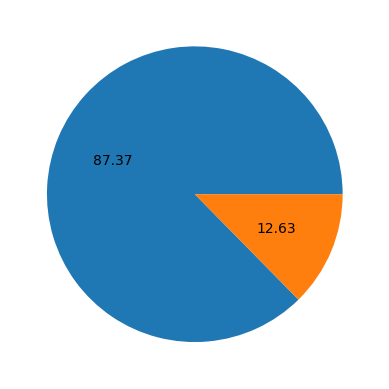

In [247]:
plt.pie(df['target'].value_counts(),autopct='%0.2f')
# data is imbalanced

In [248]:
# extract number of characters
df['num_characters'] = df['text'].apply(len)

In [249]:
# extract number of words
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [250]:
# extract number of sentences
df['num_sentences']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [251]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [252]:
# description for ham messages
df[df['target']==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [253]:
# description for spam messages
df[df['target']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

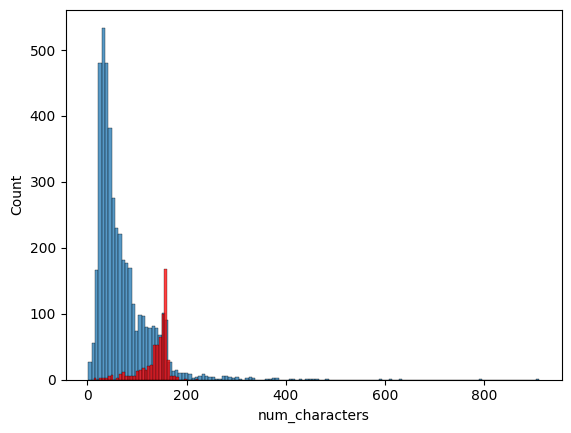

In [254]:
# plot histogram of number of characters for ham and spam messages
sns.histplot(df[df['target']==0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

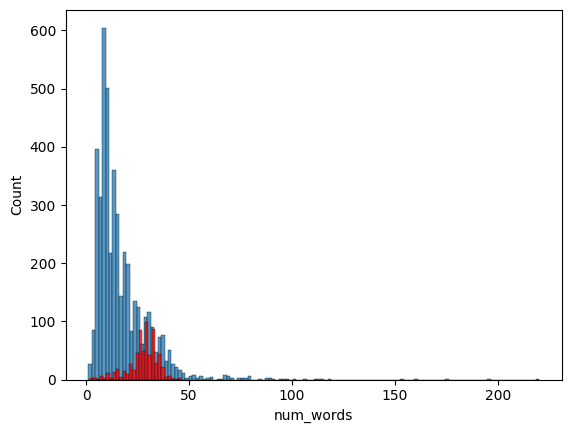

In [255]:
#  plot histogram of number of words for ham and spam messages

sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'],color='red')

# Data Preprocessing

In [256]:
ps = PorterStemmer()

In [257]:
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)
  ans = []
  for i in text:
    if  i.isalnum():
      ans.append(i)
  # text = ''.join(ans)
  text = ans[:]
  ans.clear()
  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      ans.append(i)
  # text = ''.join(ans)
  text = ans[:]
  ans.clear()
  for i in text:
    ans.append(ps.stem(i))
  return ' '.join(ans)




In [258]:
df['transformed_text'] = df['text'].apply(transform_text)

In [259]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=' '))


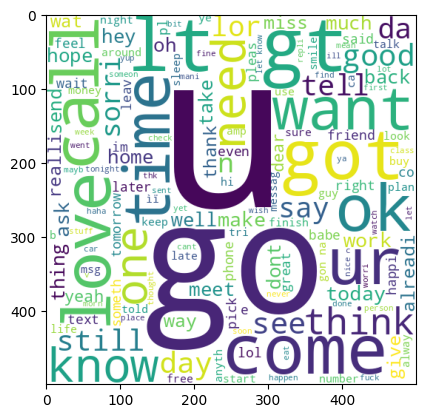

In [260]:
plt.imshow(spam_wc)

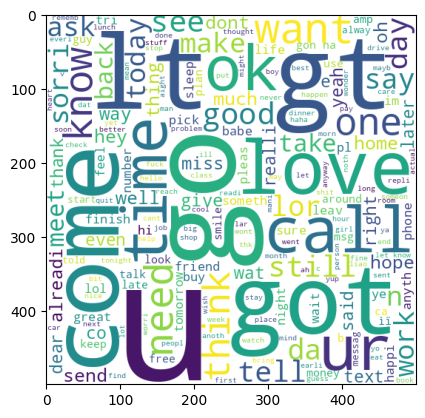

In [261]:
ham_wc = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=' '))
plt.imshow(ham_wc)

In [262]:
pd.Series((df[df['target']==0]['transformed_text'].str.cat(sep=' ')).split()).value_counts()

,count
u,883
go,404
get,349
gt,288
lt,287
...,...
veget,1
aww,1
pose,1
comb,1


<Axes: xlabel='0'>

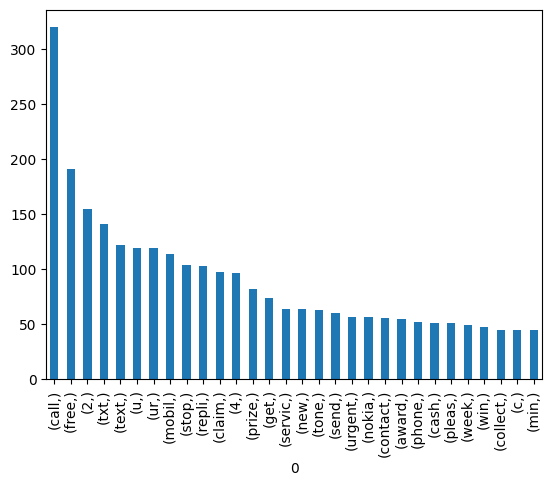

In [263]:
pd.DataFrame((df[df['target']==1]['transformed_text'].str.cat(sep=' ')).split()).value_counts().head(30).plot(kind='bar')

<Axes: xlabel='0'>

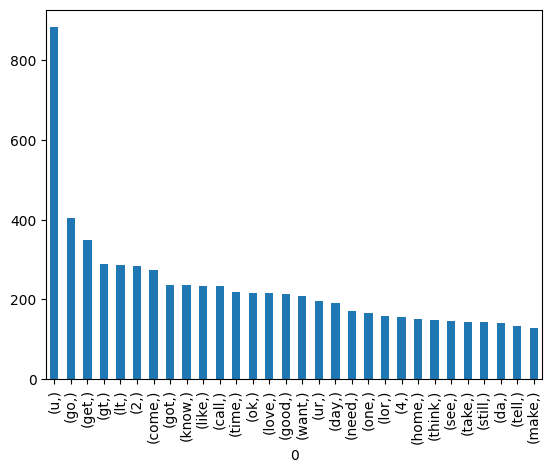

In [264]:
pd.DataFrame((df[df['target']==0]['transformed_text'].str.cat(sep=' ')).split()).value_counts().head(30).plot(kind='bar')

# Model Building

In [265]:
cv = CountVectorizer()
X = cv.fit_transform(df['transformed_text']).toarray()

In [266]:
y = df['target'].values

In [267]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [268]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
print(accuracy_score(y_test,nb.predict(X_test)))
print(precision_score(y_test,nb.predict(X_test)))

0.9661508704061895
0.9661016949152542


In [269]:
pickle.dump(cv,open('CountVectorizer.pkl','wb'))

In [270]:
pickle.dump(nb,open('BernoulliNaiveBayes.pkl','wb'))